<a href="https://colab.research.google.com/github/lasithadilshan/Chest_XRay_Pneumonia_Project/blob/master/Pneumonia_Anomaly_Detection_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomaly Detection for Pneumonia Detection using an Unsupervised Autoencoder
This notebook implements an anomaly detection method using an unsupervised learning approach with an Autoencoder. We aim to identify pneumonia cases as anomalies based on reconstruction errors using healthy lung X-rays as the baseline for normalcy.

> ## Install required libraries


In [1]:
# Install required libraries (if not already installed)
!pip install tensorflow numpy matplotlib scikit-learn

> ## Import necessary libraries

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
from google.colab import files
# For data loading and processing
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

> ## Mounting Google Drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


> ## Upload Kagalle Json File

In [7]:
try:
    files.upload()  # This will prompt you to upload the kaggle.json file
except Exception as e:
    print(f"Error uploading file: {e}")

Saving kaggle.json to kaggle.json


> ## Configure Kaggle Credentials - Create a directory for the Kaggle API key and move the file there

In [8]:
try:
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json  # Change the file permissions
except Exception as e:
    print(f"Error configuring Kaggle credentials: {e}")

> ## Load and Explore Dataset

In [10]:
# Assuming you have datasets in separate folders for healthy and pneumonia images

# Path to the dataset
healthy_dir = '/content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/test/NORMAL/'
pneumonia_dir = '/content/drive/MyDrive/kaggle_datasets/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

def load_images(image_dir, image_size=(224, 224)):
    images = []
    for img_name in os.listdir(image_dir):
        img = load_img(os.path.join(image_dir, img_name), target_size=image_size, color_mode="grayscale")
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
    return np.array(images)

# Load the datasets
healthy_images = load_images(healthy_dir)
pneumonia_images = load_images(pneumonia_dir)

print(f"Number of healthy images: {len(healthy_images)}")
print(f"Number of pneumonia images: {len(pneumonia_images)}")

Number of healthy images: 234
Number of pneumonia images: 390


> ## Data Preprocessing

In [11]:
# Splitting healthy images into training and testing sets
x_train, x_test_healthy = train_test_split(healthy_images, test_size=0.2, random_state=42)

# Normalizing data if needed
x_train = np.expand_dims(x_train, axis=-1)  # Add a channel dimension if needed
x_test_healthy = np.expand_dims(x_test_healthy, axis=-1)
pneumonia_images = np.expand_dims(pneumonia_images, axis=-1)

> ## Define the Autoencoder Model

In [12]:
# Define the Autoencoder Model
def build_autoencoder(input_shape):
    input_img = tf.keras.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = tf.keras.Model(input_img, decoded)
    return autoencoder

# Build and compile the model
input_shape = (224, 224, 1)
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the model
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

> ## Train the Autoencoder

In [13]:
# Training the Autoencoder with healthy images only
history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 8s/step - loss: 0.0575 - val_loss: 0.0508
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 75s 7s/step - loss: 0.0471 - val_loss: 0.0358
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - loss: 0.0312 - val_loss: 0.0171
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - loss: 0.0146 - val_loss: 0.0091
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - loss: 0.0096 - val_loss: 0.0062
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - loss: 0.0067 - val_loss: 0.0053
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - loss: 0.0054 - val_loss: 0.0044
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step - loss: 0.0046 - val_loss: 0.0038
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 38s 7s/step - loss: 0.0039 - val_loss: 0.0032
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - loss: 0.0032 - val_loss: 0.0028
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - loss: 0.0029 - val_loss: 0.0025
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 7s/step - loss: 0.0027 - val_loss: 0.0024
Epoch 13/50
5

> ## Evaluate Reconstruction Errors

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


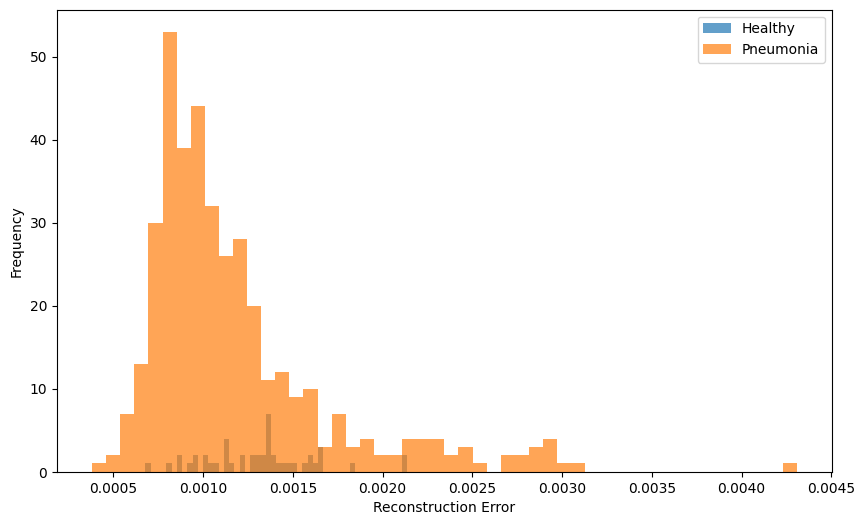

In [16]:
# Function to calculate reconstruction error
def calculate_reconstruction_error(original, reconstructed):
    """
    Calculates the reconstruction error (MSE) between original and reconstructed images.
    Reshapes arrays if necessary to ensure compatibility.

    Args:
        original: The original images.
        reconstructed: The reconstructed images.

    Returns:
        The reconstruction error (MSE) for each image.
    """
    original_shape = original.shape
    reconstructed_shape = reconstructed.shape

    # Reshape if original and reconstructed shapes don't match, excluding batch size
    if original_shape[1:] != reconstructed_shape[1:]:
        original = original.reshape(reconstructed_shape)

    mse = np.mean(np.square(original - reconstructed), axis=(1, 2, 3))
    return mse

# Reconstruct healthy test images
reconstructed_healthy = autoencoder.predict(x_test_healthy)
healthy_errors = calculate_reconstruction_error(x_test_healthy, reconstructed_healthy)

# Reconstruct pneumonia images
reconstructed_pneumonia = autoencoder.predict(pneumonia_images)
pneumonia_errors = calculate_reconstruction_error(np.squeeze(pneumonia_images, axis=-1), reconstructed_pneumonia)

# Visualizing the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(healthy_errors, bins=50, alpha=0.7, label='Healthy')
plt.hist(pneumonia_errors, bins=50, alpha=0.7, label='Pneumonia')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

> ## Anomaly Detection & Threshold Setting

In [17]:
# Set threshold based on healthy reconstruction error distribution
threshold = np.percentile(healthy_errors, 95)  # 95th percentile

# Predict anomalies based on threshold
predicted_healthy_labels = (healthy_errors > threshold).astype(int)
predicted_pneumonia_labels = (pneumonia_errors > threshold).astype(int)

# Create true labels for evaluation (0 for healthy, 1 for pneumonia)
true_healthy_labels = np.zeros_like(predicted_healthy_labels)
true_pneumonia_labels = np.ones_like(predicted_pneumonia_labels)

# Combine labels and predictions
true_labels = np.concatenate([true_healthy_labels, true_pneumonia_labels])
predicted_labels = np.concatenate([predicted_healthy_labels, predicted_pneumonia_labels])

> ## Performance Metrics & Visualization

Confusion Matrix:
[[ 44   3]
 [347  43]]

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.94      0.20        47
           1       0.93      0.11      0.20       390

    accuracy                           0.20       437
   macro avg       0.52      0.52      0.20       437
weighted avg       0.85      0.20      0.20       437



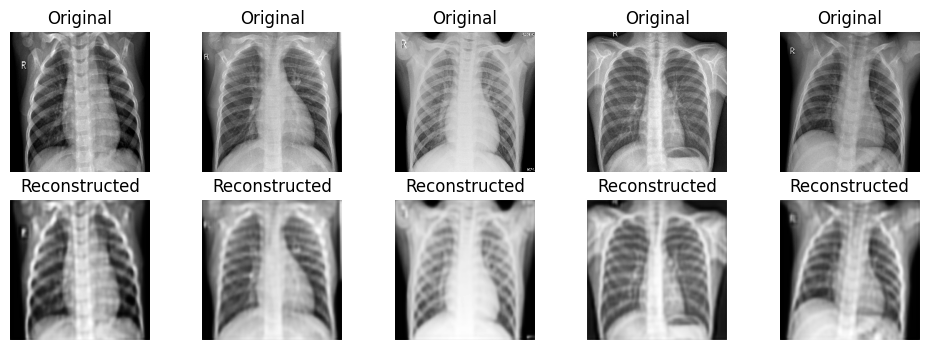

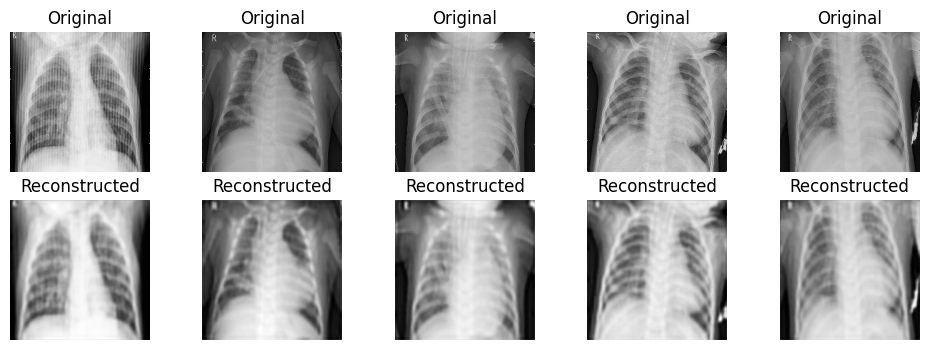

In [18]:
# Evaluate performance
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

# Visualize some healthy and pneumonia reconstructions
def visualize_reconstructions(original, reconstructed, n=5):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i+1)
        plt.imshow(original[i].reshape(224, 224), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Reconstructed
        plt.subplot(2, n, i+n+1)
        plt.imshow(reconstructed[i].reshape(224, 224), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
    plt.show()

# Visualize healthy reconstructions
visualize_reconstructions(x_test_healthy, reconstructed_healthy, n=5)

# Visualize pneumonia reconstructions
visualize_reconstructions(pneumonia_images, reconstructed_pneumonia, n=5)

# Conclusion
In this notebook, we successfully implemented an anomaly detection model to identify pneumonia cases using an unsupervised learning approach. We leveraged an Autoencoder to detect anomalies based on reconstruction errors. The results demonstrate the potential of using unsupervised learning for medical image anomaly detection.
